In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

## check datasets

In [6]:
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

In [7]:
# cat : categorical
# integer 0 to n
# bin : binary
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [8]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


## Meta data

In [9]:
# use meta data 
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)

In [10]:
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata.head()

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual


In [11]:
# use meta data, we can extract data
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [12]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


## Data analysis and statistic

### target variable

<Figure size 432x288 with 0 Axes>

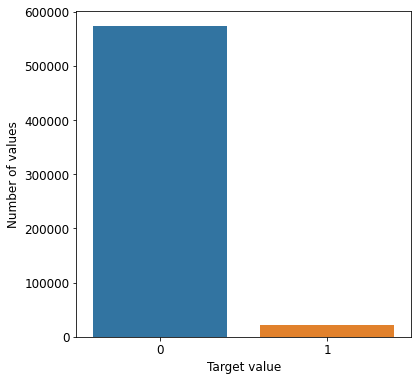

In [13]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### real features

In [14]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [15]:
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [16]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### features with missing values
- ps_reg_o3, os_car_12, ps_car_14 가 결측값을 가진다. 

### registration features
- ps_reg_01, ps_reg_02 데이터는 분모가 10인 데이터이다(확률적인 데이터일 것)

### car features
- ps_car_12는 ps_car_15값에 루트값을 씌운 형태이다. (pair형태임)

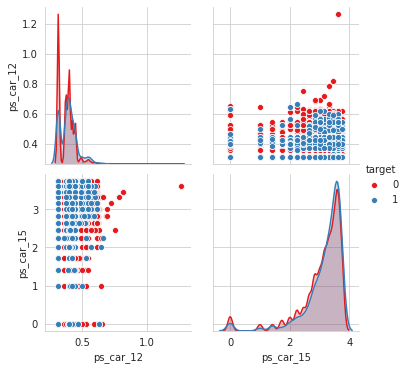

In [23]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### calculated features
- ps_calc_01, ps_clac_02, ps_clac_03은 비슷한 분포를 보인다. 

<Figure size 432x288 with 0 Axes>

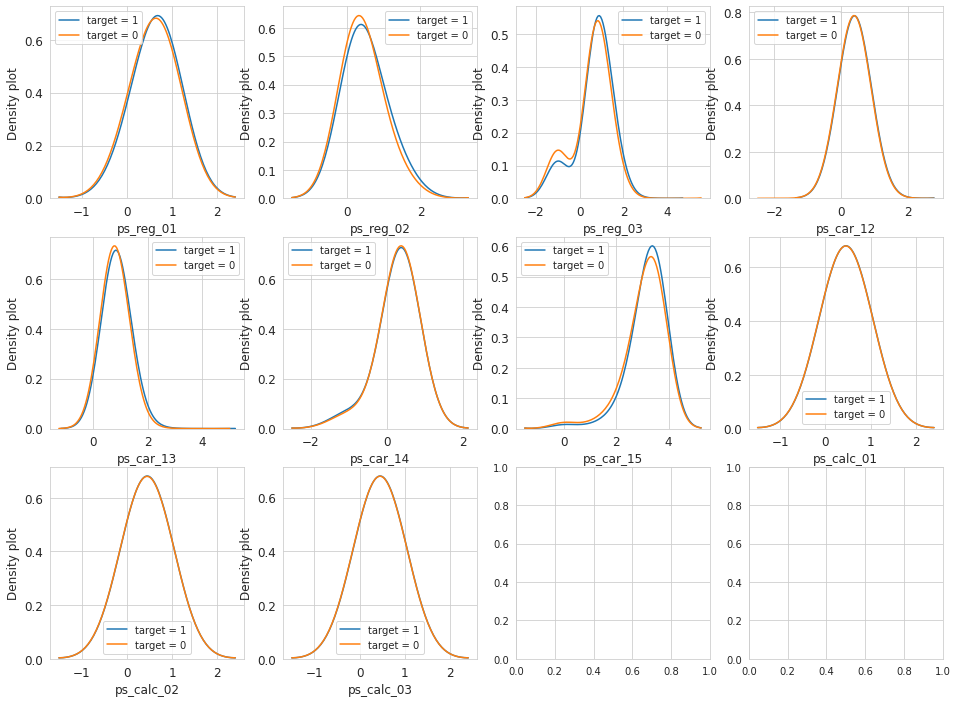

In [26]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [27]:
# 각 변수들 사이의 상관관계 확인 
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();

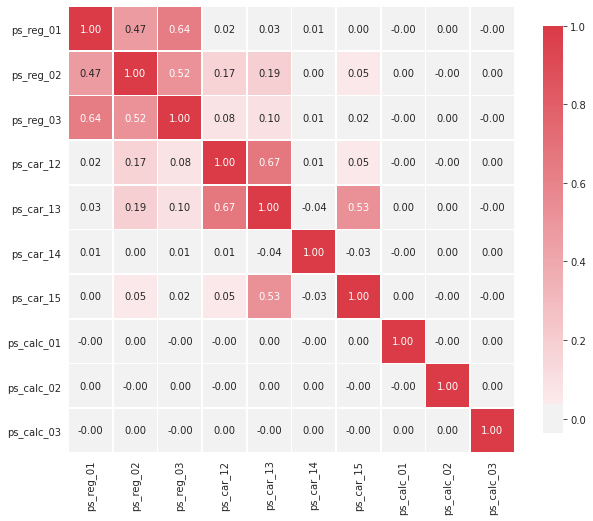

In [28]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

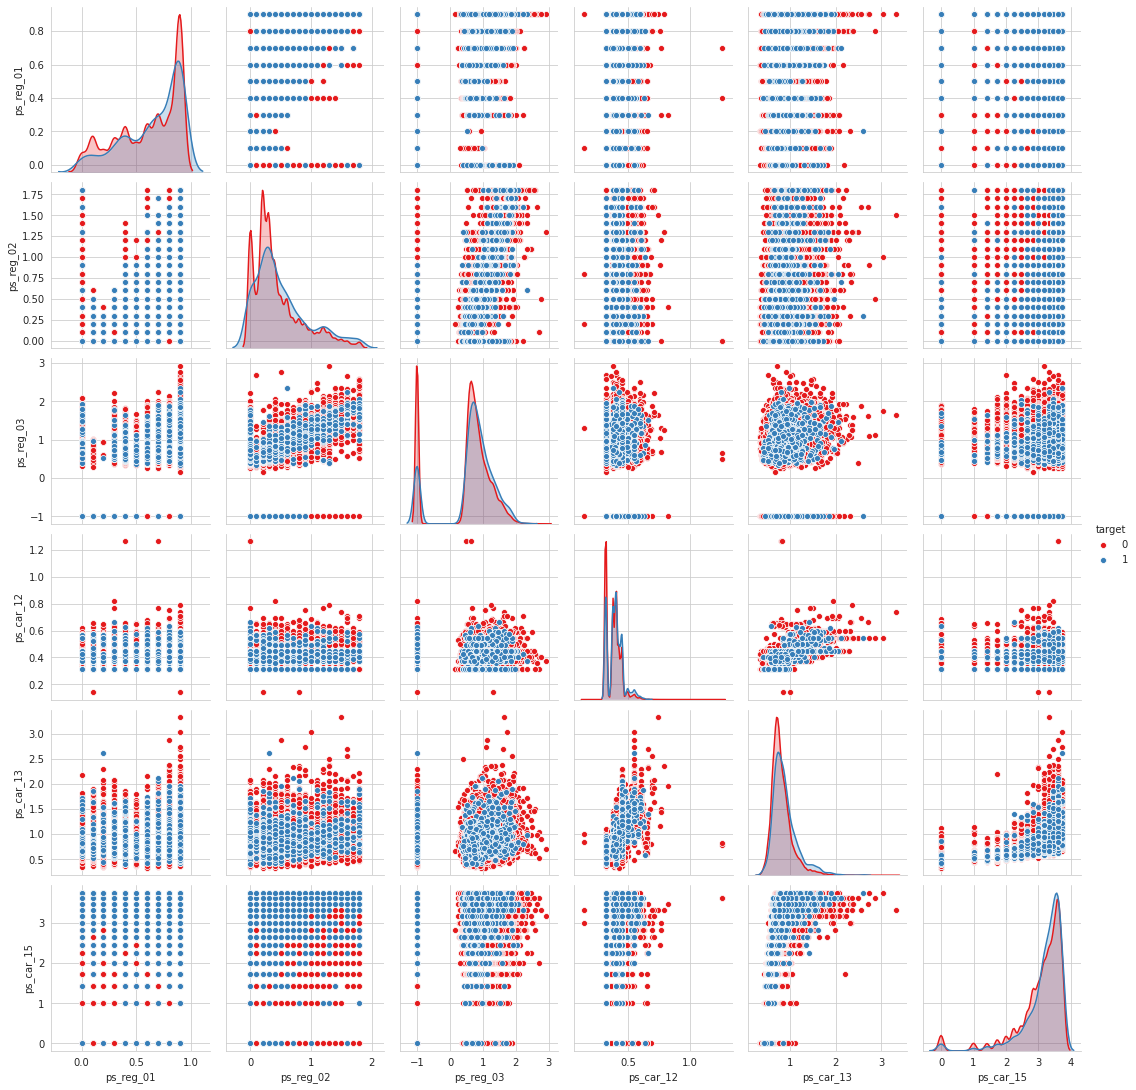

In [29]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

## data unbalanced between train and test data

### reg or registration features

In [30]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

<Figure size 432x288 with 0 Axes>

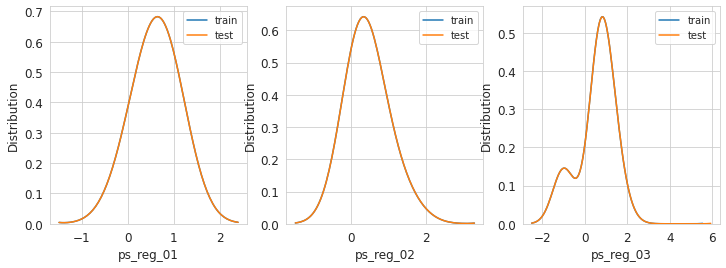

In [31]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### car features

In [32]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

<Figure size 432x288 with 0 Axes>

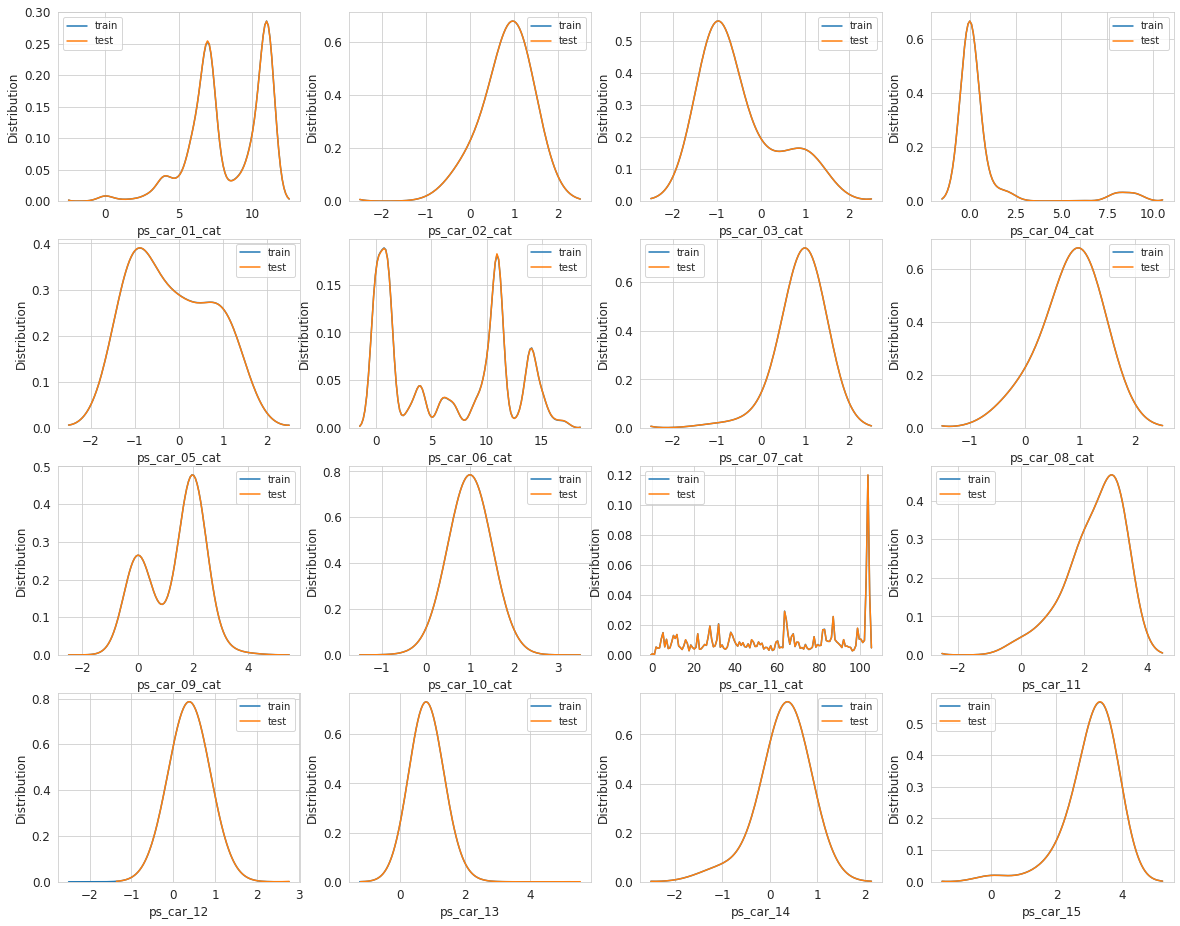

In [33]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### ind values

In [34]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

<Figure size 432x288 with 0 Axes>

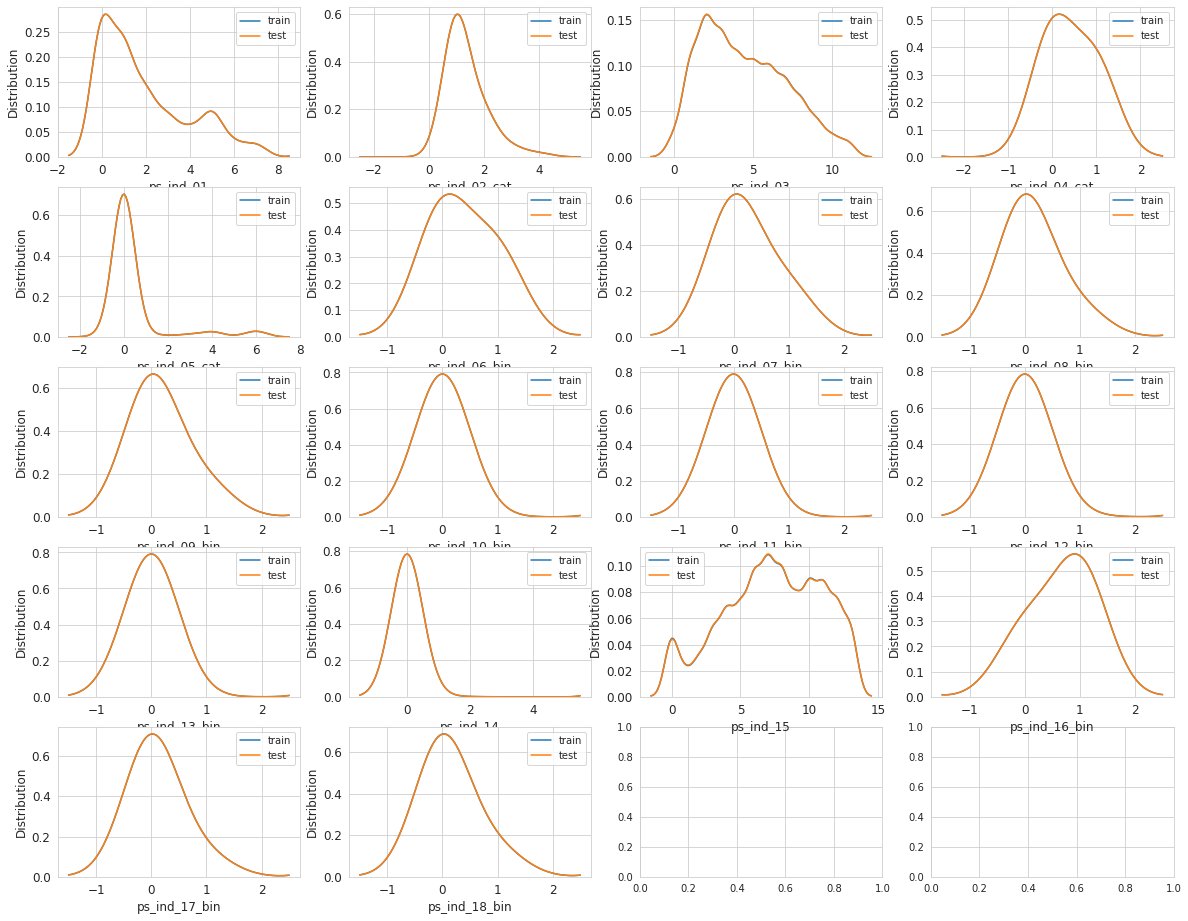

In [35]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### clac features

In [36]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

<Figure size 432x288 with 0 Axes>

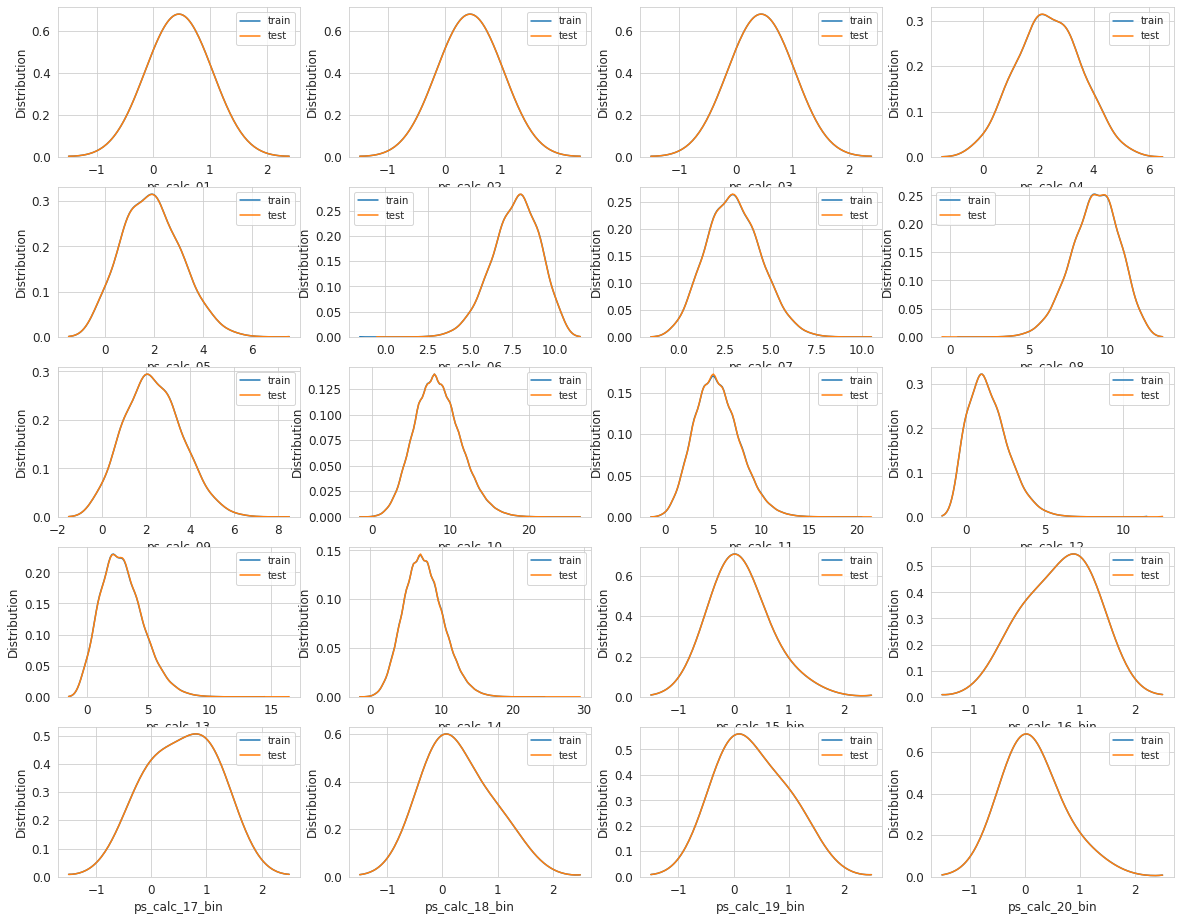

In [37]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

## check data quality

### inspect missing values

In [38]:
vars_with_missing = []

In [39]:
for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values


In [40]:
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

In total, there are 13 variables with missing values


## Prepare the data for model

### drop calc col

In [41]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)  
testset = testset.drop(col_to_drop, axis=1) 

### drop variables with too many missing values

In [42]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False  # Updating the meta

In [43]:
# use smoothing 
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [45]:
def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
  
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)

    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])

    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))

    # Apply average function to all target data
    prior = target.mean()

    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)

    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### replace ps_car_11_cat with encoded value

In [46]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [47]:
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # Updating the metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

### balanced target value

In [48]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


### replace -1 values with Nan

In [49]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### dummify cat values

In [50]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

In [51]:
for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)

In [52]:
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

### drop unused and target columns

In [53]:
id_test = testset['id'].values
target_train = trainset['target'].values

In [54]:
trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

## Prepare the model

In [55]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

### hyperparameters for basemodels

In [56]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

### init the models with the hyperparameters

In [57]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

### init the ensemble object

In [58]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

In [ ]:
# predict
y_prediction = stack.fit_predict(trainset, target_train, testset)      

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63695 [gini]: 0.27390
Base model 1: fit LGBMClassifier model | fold 2


## submission

In [ ]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)